# Overview

This notebook details my approach to solving the [Kaggle Readability Competition](https://www.kaggle.com/c/commonlitreadabilityprize/overview). More specifically, this notebook details how I finetuned one of [HuggingFace's DistilBert networks](https://huggingface.co/transformers/model_doc/distilbert.html) to estimate the readability of pieces of text. 

At a 'high level', finetuning just refers to adjusting the weights of a network has already been trained on a much larger data set (but for a task and/or on a data set which is different from the one we're currently interested in) by training that same network on our much smaller data set. The key intuition behind why this works is that the network is able to *transfer* what it learnt from the large data set to doing well on our much smaller training data set.


# Set-Up


Before doing anything else, let's first install the required packages for this notebook:

In [ ]:
!pip install -r ./requirements.txt

Next, let's perform our imports:

In [ ]:
# PyTorch imports:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils import data 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset

# HuggingFace imports:
import transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW

# Data manipulation imports:
import pandas as pd
from sklearn.model_selection import train_test_split

# Plotting imports:
import seaborn as sns
import matplotlib.pyplot as plt

# Misc imports:
import itertools
import random
import time
import shutil
from math import inf

Let's set the verbosity of the HuggingFace library so that it only prints 'Critical' messages:

In [ ]:
transformers.logging.set_verbosity(transformers.logging.CRITICAL)

Let's set our PyTorch device to be a GPU (if one is available):

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

For reproducability, we'll set our random seeds:

In [ ]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Finally, we'll define the name of the DistilBert model we'll use from the HuggingFace library:

In [ ]:
MODEL_NAME = "distilbert-base-uncased"

# Load in Data and Tokenizer

Let's now load in the data (i.e. `train.csv`) - we'll throw away everything which *isn't* the text excerpt and the target value:

In [ ]:
# Load data:
text_dir = "./train.csv"
text_df = pd.read_csv(text_dir)
text_df = text_df.loc[:,"excerpt":"standard_error"]

# Split loaded data into features X and labels y:
features, labels = text_df.loc[:,"excerpt"].to_frame(), text_df.loc[:,"target"].to_frame()

Next, let's create the *tokenizer* we'll use to convert our excerpts of text into numerical ID vectors which can be understood by BERT:

In [ ]:
TOKENIZER = DistilBertTokenizer.from_pretrained(MODEL_NAME, use_fast=True, do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

For reproducability, let's also save this tokenizer:

In [ ]:
TOKENIZER.save_pretrained('tokenizer')

# Token Lengths

## The Problem of Choosing the Maximum Token Length

As we previously alluded to, one must *tokenise* a string before passing it to BERT as an input - in other words, a string must be converted to a vector of numerical ID values. Importantly, the length of these numerical ID vectors will depend on the length of the sentence being tokenized. 

Critically, BERT is unable to process inputs which are longer than 500 tokens, so it's important to figure out if we have any text excerpts which are longer than length. Additionally, the computational cost of using BERT increases *quadratically* with token length (i.e. doubling the token length quadruples the computation time). Both of these facts mean that we must decide on a **maximum token length** to consider - importantly, one must recognise that there is a *trade-off* when deciding on the maximum token length:
  - If we pick a token length which is unneccassarily large, our network will be a lot slower to train.
  - If we pick a token length which is too small, the network may perform poorly, since there is less information about 'readability' within a shorter pice of text. Indeed, one may actually wonder what we do with the rest of a piece of tokenised text if its length exceeds our 'maximum length' - we'll discuss this issue shortly.




## Token Length Distribution in our Data

To get an understanding of the token lengths corresponding to the text excerpts in our data set, we'll tokenize every input in our data set and then plot the distribution of token lengths:

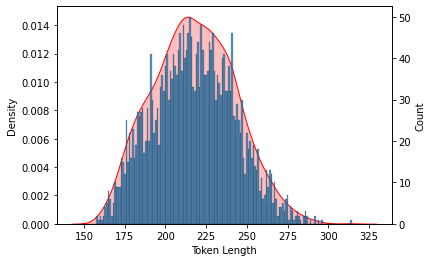

In [ ]:
# Initialise list to store tokens in:
token_len = []

# Tokenize every piece of text in training dataset:
for text in features["excerpt"]:
  tokens = TOKENIZER.encode(text, truncation=False)
  token_len.append(len(tokens))

# Plot these token lengths:
fig, ax1 = plt.subplots()
plt.xlabel('Token Length')
sns.kdeplot(data=token_len, ax=ax1, color='r', fill=True)
ax2 = ax1.twinx()
sns.histplot(data=token_len, discrete=True, ax=ax2)
sns.set_style("darkgrid")

As we can see from the above plot, the token lengths vary between 150 and 300. We'll revisit this issue of choosing a token length when we discuss hyperparameter tuning at the end of this notebook.

## What Happens if Our Input Text Extracts are Longer than the Maximum Token Length?

We previously noted that it's unclear what happens if we choose a maximum token length which is **less than the token length of a particular piece of text**. One way to solve this problem would be to *throw away* all of the token values which occur after our cut-off length; this, however, is wasteful, since we're effectively 'throwing away' a lot of our data. 

Another solution to this problem would be to simply **slice up** those *training examples longer than the maximum length into multiple new training example*. This means, for example, that if our maximum token length was set to 100, then a text whose tokenisation is 300 values long would be 'sliced' up into *three new training example tokenisations of size 100*. By doing this, we're throwing away a lot less data. 

This slicing idea makes sense in the context of training our network (i.e. one training example is sliced into multiple training examples), but what happens if we're using our network to *predict* a readability value? How do we go from multiple readability predictions made on sub-string slices of an input into a single readability prediction for the entire string? One simple way to do this would be to compute the **weighted average of the readability scores across all of the token slices**:

$
\text{Predicted Readability of Text} = \sum_{i=0}^{i=N}\frac{\text{Length of Token Slice} i}{\text{Total Token Length of Text}}\times \text{Readability of Token Slice }i
$

By taking this weighted average, we 'pay less attention' to those readability predictions made on shorter text slices (which are probably less accurate than predictions made on longer slices of text). Indeed, we may even want to filter out those slices of text which are **shorter than a specified length** to prevent outlier text slices from unduly swaying our prediction about the entire string.

## Padding to the Maximum Token Length and Attention Masks

In theory, it should be fine if a text input has a tokenisation which is shorter than our chosen maximum token length.

In practice, however, this **is a problem** - this is because neural networks runs **much faster** if our input data is stored in a **single tensor data structure**. But in order to store all of our inputs in a single tensor, they all need to be of the **same length**. In order to ensure that our input tokens are all of the same length, we need to **pad input tokens shorter than the maximum token length with zeros** (i.e. add zero values to the end of the token). That way, we can be sure all of our input features are the same length.

But this padding is entirely artificial, and should not influence the predictions made by the network - how do we tell our BERT network to 'ignore' these zero paddings? It turns out we can use something call an **attention mask** to label those parts of our token input which we want the network to 'pay attention' to (these tokens are labelled with a `1` in the attention mask), and which parts of the token input we don't want the netowkr to 'pay attention' to (these parts are labelled with a `0` in the attention mask). This is all important to know when we finally look at our data pre-processing code.

## Maximum Token Length as a Hyperparameter

At this point, it's worth noting that it would actually be ideal if we would choose the minimum possible token length which still allows our network to perform well - that way, our network can run both **accurately an efficiently**. For this reason, we'll actually explore **multiple different maximum token length values when we consider hyperparameter tuning later on in this notebook**.

# Pre-Process Data

Let's now split our data into a training dataset (90% of the data) and test dataset (10% of the data). Since our dataset is relatively large here (around 2000 instances), 10% of the dataset should be enough to get a statistically robust estimate of the generalisation error of our network:

In [ ]:
test_frac = 0.1
train_features, test_features, train_labels, test_labels \
  = train_test_split(features, labels, test_size=test_frac, random_state=RANDOM_SEED)
TRAIN_DATA = {"features": train_features, "labels": train_labels}
TEST_DATA = {"features": test_features, "labels": test_labels}

We now need to process our training and test datasets into tokens which can be 'understood' by BERT. To do this, we'll define the following three major functions:
1. `create_train_dataset` - This takes in our **training** data set, tokenises each input, and then slices up these tokenized inputs if they exceed a specified maximum length `max_len` or, alternatively, pads our input tokens if they're shorted than `max_len`. Additionally, it also throws away any text slices which are shorted than `cutoff` in length - for our purposes, we've (relatively arbitrarily) set this `cutoff` value to `30` (i.e. all those token slices with fewer than 30 values will be thrown away). The output of this function are **three tensors**:
  - `X_id`, which is a tensor with dimensions `num_extracts × max_num_slices × max_len`, where `num_extracts` is the total number of extracts in our training data, and `max_num_slices` is the *maximum* number of token slices yielded by slicing up an extract accross our entire dataset. Put simply, the `0'th` access is used to access a specific extract, the `1'st` axis corresponds to a particular slice within that extract, and the `2'nd` axis corresponds to a particular token within the slice of that extract. 
  - `X_mask`, which stores the attention masks corresponding to the tokenised inputs stored in `X_id` - it's dimensions are the same as that of `X_id`
  - `y`, which stores the labels of our training examples, and is of dimensions `num_extracts × num_pred`, where `num_pred` is the number of values we're trying to predict (which `= 1` here).
2. `create_test_dataset` - This takes in our **test** data set, and basically does the same thing as `create_train_dataset`. The only difference is is that this function also returns an `X_wts` tensor, which is a `num_extracts × max_num_slices` tensor which contains the weights used to compute the weighted average readabilities for each extract by averaging the readability predictions for each slice for that particular extract.
3. `tokenise_inputs` - This function, which is called by `create_train_dataset` and `create_test_dataset`, simply tokenises and slices up all of the txt extracts it's given. To achieve this, it calls a helper function called `process_chunks`, adds the start and end ID values to each of these slices, (which are special values used by BERT to recognise the start and end of an input) and pads chunks which are shorter than `max_len`.

With those descriptions out of the way, let's now define these functions:

In [ ]:
def create_train_dataset(train_data, tokenizer, max_len, cutoff=30, print_flag=False):

  train_features, train_labels = train_data["features"], train_data["labels"]

  # Convert labels to PyTorch tensors:
  y = torch.tensor(train_labels["target"].values, dtype=torch.float32)
  y = y.reshape((len(y), 1)) 

  # Split text into chunks and tokenise those chunks:
  X_id, X_mask = tokenise_inputs(train_features, tokenizer, max_len, cutoff)

  # Repeat labels for every chunk:
  num_chunks_per_ex = X_id.shape[1]
  y = y.repeat_interleave(num_chunks_per_ex, 0)

  # Reshape X_id and X_mask to ([batch size*num of chunks] × num of mask/id values):
  new_shape = (X_id.shape[0]*X_id.shape[1], X_id.shape[2])
  X_id, X_mask = X_id.reshape(new_shape), X_mask.reshape(new_shape)

  # Create mask to throw away sentence chunks below cutoff length:
  chunk_mask = torch.sum(X_mask, axis=1) >= cutoff

  # Print output to user:
  if print_flag:
    # Compute number of (non-empty) sentence chunks and tokens to throw away:
    thrown_chunks = (torch.logical_and(torch.logical_not(chunk_mask), torch.sum(X_mask, axis=1)>0)).sum()
    total_chunks = (torch.sum(X_mask, axis=1) > 0).sum()
    thrown_tokens = X_mask[torch.logical_not(chunk_mask),:].sum()
    total_tokens = X_mask.sum()
    print("Training Data Processing Summary:")
    print(f"Number of sentence chunks discarded = {torch.sum(thrown_chunks)}/{torch.sum(total_chunks)}")
    print(f"Number of tokens discarded = {thrown_tokens}/{total_tokens}")

  # Throw away sentence chunks which contain fewer than cutoff ids:
  X_id, X_mask, y = X_id[chunk_mask,:], X_mask[chunk_mask,:], y[chunk_mask,:]
  
  # Place in dataset:
  train_dataset = TensorDataset(X_id, X_mask, y)
  return train_dataset

In [ ]:
def create_test_dataset(test_data, tokenizer, max_len, cutoff=30):

  test_features, test_labels = test_data["features"], test_data["labels"]

  # Convert labels to PyTorch tensors:
  y = torch.tensor(test_labels["target"].values, dtype=torch.float32)
  y = y.reshape((len(y), 1)) 

  # Split text into chunks and tokenise those chunks:
  X_id, X_mask = tokenise_inputs(test_features, tokenizer, max_len, cutoff)

  # Compute weightings for the sentence chunks:
  X_wts = torch.sum(X_mask, axis=2, keepdim=True)/torch.sum(X_mask, axis=(1,2), keepdim=True)
  X_wts = X_wts.reshape(X_mask.shape[0:-1])
  X_wts = torch.as_tensor(X_wts, dtype=torch.float32)
  
  # Place tensors into dataset:
  test_dataset = TensorDataset(X_id, X_mask, X_wts, y)
  return test_dataset

In [ ]:
def tokenise_inputs(features, tokenizer, max_len, cutoff):

  X_id, X_mask = [], []

  # Loop over text excerpts:
  for text in features["excerpt"]:
    id_list, mask_list = [], []

    # Tokenize this text:
    tokens = tokenizer.encode_plus(text, add_special_tokens=False, return_tensors='pt')

    # Split into chunks of length (max_len - 2) - we still need to add the start and end
    # IDs to these slices:
    ids = tokens["input_ids"][0].split(max_len-2)
    masks = tokens["attention_mask"][0].split(max_len-2)

    # Process each id_chunk-mask_chunk pair, 
    for id_chunk, mask_chunk in zip(ids, masks):
      id_chunk, mask_chunk = process_chunks(id_chunk, mask_chunk, max_len)
      id_list.append(id_chunk), mask_list.append(mask_chunk)

    # Add these to our list:  
    X_id.append(torch.stack(id_list, dim=0))
    X_mask.append(torch.stack(mask_list, dim=0))

  # Pad list of IDs and Masks so that they're now both stored in a single tensor
  # of dimensions (num_extracts × max_num_slices × max_len):
  X_id = pad_sequence(X_id, batch_first=True, padding_value=0)
  X_mask = pad_sequence(X_mask, batch_first=True, padding_value=0)
  X_id, X_mask = torch.as_tensor(X_id, dtype=torch.int64), torch.as_tensor(X_mask, dtype=torch.int64)
  return (X_id, X_mask)

def process_chunks(id_chunk, mask_chunk, max_len, start_id=101, end_id=102):

  # Add start and stop IDs:
  id_chunk = torch.cat([torch.tensor([start_id]), id_chunk, torch.tensor([end_id])])
  mask_chunk = torch.cat([torch.ones(1), mask_chunk, torch.ones(1)])

  # Pad chunks if required:
  if len(id_chunk) < max_len:
    pad_len = max_len - len(id_chunk)
    id_chunk = torch.cat([id_chunk, torch.zeros(pad_len)])
    mask_chunk = torch.cat([mask_chunk, torch.zeros(pad_len)])

  return (id_chunk, mask_chunk)

# Create Dataset and DataLoader Objects

Now that we have our functions to pre-process our inputs, let's now define a PyTorch Dataset object to store this preprocessed data - note that the behaviour of the dataset object differs depending on whether it's loaded with training data or test data (since test data contains `X_wts`, whereas the training data does not): 

In [ ]:
class ReadingDifficultyDataset(data.Dataset):
  def __init__(self, dataset, mode):
    self.dataset = dataset
    self.mode=mode

  def __len__(self):
    return len(self.dataset)
    
  def __getitem__(self, idx):
    item_i = self.dataset[idx]
    if self.mode=="train":
      item_i = {"id": item_i[0],
                "mask": item_i[1],
                "y": item_i[2]}
    elif self.mode=="test":
      item_i = {"id": item_i[0],
                "mask": item_i[1],
                "wt": item_i[2],
                "y": item_i[3]}
    return item_i

We can then define functions to create Dataloader objects corresponding to these Dataset objects:

In [ ]:
BATCH_SIZE = 32

def create_train_dataloader(train_data, max_len, tokenizer, batch_size=BATCH_SIZE):
  train_dataset = create_train_dataset(train_data, tokenizer, max_len)
  train_dataset = ReadingDifficultyDataset(train_dataset, "train")
  train_dl = data.DataLoader(train_dataset,
                             batch_size=batch_size,
                             shuffle=True)
  return train_dl

def create_test_dataloader(test_data, max_len, tokenizer, batch_size=BATCH_SIZE):
  test_dataset = create_test_dataset(test_data, tokenizer, max_len)
  test_dataset = ReadingDifficultyDataset(test_dataset, "test")
  test_dl = data.DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)
  return test_dl

# Create BERT Model

We'll now define an object to represent our BERT model - during the initialisation of our model, we simply take note of how many quantities we're predicting and then load in a pre-trained BERT model from the HuggingFace library. Note that the constructor also accepts a `drop_prob` parameter, which can be used to specify the dropout probability of the final dropout layer of the BERT network - this will later be varied as a hyper parameter.

We've also defined a `predict` method, which predicts the readability of **test examples by computing the weighted average readability of each extract**.

In [ ]:
class BertRegression():
  def __init__(self, num_pred, drop_prob):

    self.num_pred = num_pred
    self.model = \
     DistilBertForSequenceClassification.from_pretrained(MODEL_NAME,
                                                         problem_type="regression",
                                                         num_labels=num_pred,
                                                         seq_classif_dropout=drop_prob,
                                                         output_attentions=False,
                                                         output_hidden_states=False)

  def predict(self, id, att_mask, wt):
    
    # Check that model is in evaluation mode, not training mode:
    if self.model.training:
      self.model.eval()
    
    # Determine input and output shapes:
    in_shape = (id.shape[0]*id.shape[1], id.shape[2])
    out_shape = id.shape[0:-1] + (self.num_pred,)

    # Reshape id and attention mask accordingly:
    id, att_mask = id.reshape(in_shape), att_mask.reshape(in_shape)
    
    # Make prediction using BERT model:
    logits = self.model(input_ids=id, attention_mask=att_mask)["logits"]
    
    # Reshape output:
    logits = logits.reshape(out_shape)

    # Compute weighted average of slices for each excerpt:
    pred = torch.einsum("ij,ijk->ik", wt, torch.nan_to_num(logits))
    return pred

# Train and Evaluation Loops

Let's now define our functions to run a single epoch of our training loop and our test loop:

In [ ]:
def train_epoch(model_obj, data_loader, optimiser, device):
  
  # Make sure model is in training mode:
  model_obj.model.train()

  # Initialise loss for this epoch:
  total_loss = 0

  for d in data_loader:

    # Unpack training data:
    id = d["id"].to(device)
    mask = d["mask"].to(device)
    y = d["y"].to(device)

    # Produce predictions:
    model_obj.model.zero_grad()
    output = model_obj.model(input_ids=id, 
                             attention_mask=mask, 
                             labels=y)
    # Add to loss:
    total_loss += output.loss.item()

    # Perform backprop:
    output.loss.backward()

    # Update parameters:
    optimiser.step()

  # Return average loss across all samples:
  return total_loss/len(data_loader)

In [ ]:
def test_epoch(model_obj, data_loader, test_loss_fun, device):
  
  # Make sure model is in evaluation mode:
  model_obj.model.eval()

  # Initialise loss:
  total_loss = 0

  # Don't need to track gradient since we're not training here:
  with torch.no_grad():
    for d in data_loader:

      # Unpack training data:
      id = d["id"].to(device)
      mask = d["mask"].to(device)
      wt = d["wt"].to(device)
      y = d["y"].to(device)

      # Produce predictions:
      pred = model_obj.predict(id, mask, wt)
      loss = test_loss_fun(pred.squeeze(), y.squeeze())

      # Add to tests:
      total_loss += loss

    # Return average test loss:
  return total_loss/len(data_loader)

We can now define a function which trains our BERT model for a **single set of hyperparameters**:

In [ ]:
def train_model(model_obj, optimiser, train_dl, test_dl, num_epoch, device, 
                print_msg=False, delete_model=True):

  # Define print function to use depending on if user wants printed outputs:
  my_print = print if print_msg else lambda my_str: None

  # Move test loss and model to GPU:
  test_loss_fun = nn.MSELoss().to(device)
  model_obj.model.to(device)

  # Save training and test loss history:
  hist = {"train": [], "test": []}
  best_loss = inf

  for i in range(num_epoch):

    # Print info to user:
    my_print(f'Epoch {i+1}/{num_epoch}')
    my_print(10*'-')

    # Compute training loss:
    time_0 = time.time()
    train_loss = train_epoch(model_obj, train_dl, optimiser, device)
    time_1 = time.time()
    my_print(f"Train loss = {train_loss:.6f}")
    my_print(f"Training time = {time_1-time_0:.2f} seconds")

    # Compute test loss:
    time_0 = time.time()
    test_loss = test_epoch(model_obj, test_dl, test_loss_fun, device)
    time_1 = time.time()
    my_print(f"Test loss = {test_loss:.6f}")
    my_print(f"Test time = {time_1-time_0:.2f} seconds\n")

    # Save best model we've seen thus far:
    if test_loss < best_loss:
      best_loss = test_loss
      model_obj.model.save_pretrained('train_model')

    # Record training history:
    hist["train"].append(train_loss)
    hist["test"].append(test_loss)

  # Load best model we saw:
  best_model = DistilBertForSequenceClassification.from_pretrained('train_model')
  
  # Delete model if requested by user:
  if delete_model:
    shutil.rmtree('train_model')
    
  return (best_model, best_loss)

# Hyperparameter Tuning

As we've previously alluded to in this notebook, we need to perform **hyperparameter tuning** to get the best performance out of our finetuned BERT network. In this case, we consider **three hyperparameters to vary**:
1. The maximum token length - we've already discussed the rationale behind this decision.
2. The dropout probability of the final dropout layer - chosing the right dropout probability betters allows BERT to *generalise* to unseen data.
3. The learning rate - this is a 'classic' hyperparameter to vary and can have siginificant impacts on final network performance.

Importantly, parameters we choose **not** to vary include:
1. The number of epochs - we keep this fixed at `3`, which is a value recommended by most practicioners. Indeed, it's often recommended to **not** train BERT for too many epochs, or else it will begin to 'memorise' one's data too much.
2. The batch size, which is fixed at `32` - this was chosen for computational purposes, since batch sizes of `64` took up a significant amount of memory.

With this all in mind, let's now define a function which calls our `train_model` function for different combinations of hyperparameters and takes note of the best hyperparameter combination:

In [ ]:
def hp_tuning(hp_list, fixed_params, model_class, train_data, test_data, tokenizer, 
              num_epoch, device):
  
  # Create list of dictionaries for all possible hyperparameter combinations:
  keys = hp_list.keys()
  hp_combos = []
  for bundle in itertools.product(*hp_list.values()):
    hp_dict = dict(zip(keys, bundle))
    hp_combos.append(hp_dict)

  # Dictionary to store hyperparameter combinations and losses:
  results_dict = {"hp": [], "loss": [], "time": []}

  # Loop over each hyperparameter combo:
  best_loss = inf
  for i, hp in enumerate(hp_combos):

    # Start timer:
    time_0 = time.time()

    # Print progress:
    print(f"Hyper-parameter combination {i+1}/{len(hp_combos)}")

    # Create model:
    model = create_model(model_class, hp, fixed_params)

    # Create optimiser:
    optimiser = create_optimiser(model, hp, fixed_params)

    # Create Dataloaders:
    train_dl, test_dl = create_dl(train_data, test_data, tokenizer, hp, fixed_params)

    # Train model for this choice of hyperparameters:
    model, loss = train_model(model, optimiser, train_dl, test_dl, num_epoch, device)

    # Stop timer:
    time_1 = time.time()

    # Store results:
    results_dict["hp"].append(hp)
    results_dict["loss"].append(loss)
    results_dict["time"].append(time_1 - time_0)

    # Save model if it's the best we've seen thus far:
    if loss < best_loss:
      best_loss = loss
      best_hp = hp
      model.save_pretrained('best_model')
      
  return (best_hp, best_loss, results_dict)

Importantly, the above hyperparameter tuning function calls the following two helper functions to ceate the optimiser, BERT model, and dataloader corresponding to a particular combination of hyperparameters:

In [ ]:
# Function to create BERT model from hyperparameter values:
def create_model(model_class, hyper_params, fixed_params):
  model = model_class(fixed_params["num_pred"], 
                      hyper_params["drop_prob"])
  return model

# Function to create optimiser from hyperparameter values:
def create_optimiser(model_obj, hyper_params, fixed_params):
  optimiser =  AdamW(model_obj.model.parameters(), 
                     lr=hyper_params["lr"],
                     weight_decay=1e-3)
  return optimiser

def create_dl(train_data, test_data, tokenizer, hyper_params, fixed_params):
  train_dl = create_train_dataloader(train_data, 
                                     hyper_params["max_len"], 
                                     tokenizer)
  test_dl  = create_test_dataloader(test_data, 
                                    hyper_params["max_len"],
                                    tokenizer)
  return (train_dl, test_dl)

# Training the Network

Let's now actually perform our hyperparameter tuning and train our network - in this case, we've chosen three to four values for each of our hyperparameters. The values chosen are based on typically recommended values for hyperparameter tuning. In total, we have 36 hyperparameter combinations; ona Tesla T4 GPU running on Google Colab, it takes around two hours to perform this hyperparameter tuning procedure.

In [ ]:
hp_list = {"lr": [5e-5, 2.5e-5, 1e-5],
           "drop_prob": [0.15, 0.2, 0.25],
           "max_len": [100, 150, 200, 250]}
fixed_params = {"num_pred": 1}
model_class = BertRegression
num_epoch = 3
best_hp, best_loss, results_dict = \
  hp_tuning(hp_list, fixed_params, model_class, TRAIN_DATA, TEST_DATA, TOKENIZER, num_epoch, device)

Hyper-parameter combination 1/36


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Hyper-parameter combination 2/36
Hyper-parameter combination 3/36
Hyper-parameter combination 4/36
Hyper-parameter combination 5/36
Hyper-parameter combination 6/36
Hyper-parameter combination 7/36
Hyper-parameter combination 8/36
Hyper-parameter combination 9/36
Hyper-parameter combination 10/36
Hyper-parameter combination 11/36
Hyper-parameter combination 12/36
Hyper-parameter combination 13/36
Hyper-parameter combination 14/36
Hyper-parameter combination 15/36
Hyper-parameter combination 16/36
Hyper-parameter combination 17/36
Hyper-parameter combination 18/36
Hyper-parameter combination 19/36
Hyper-parameter combination 20/36
Hyper-parameter combination 21/36
Hyper-parameter combination 22/36
Hyper-parameter combination 23/36
Hyper-parameter combination 24/36
Hyper-parameter combination 25/36
Hyper-parameter combination 26/36
Hyper-parameter combination 27/36
Hyper-parameter combination 28/36
Hyper-parameter combination 29/36
Hyper-parameter combination 30/36
Hyper-parameter combin

Let's now print out the best hyperparameter combination we saw:

In [ ]:
best_hp

{'drop_prob': 0.15, 'lr': 2.5e-05, 'max_len': 250}

In [ ]:
best_loss

tensor(0.2358, device='cuda:0')

Let's also print out the entire results dictionary of our hyperparameter tuning:

In [ ]:
results_dict

{'hp': [{'drop_prob': 0.15, 'lr': 5e-05, 'max_len': 100},
  {'drop_prob': 0.15, 'lr': 5e-05, 'max_len': 150},
  {'drop_prob': 0.15, 'lr': 5e-05, 'max_len': 200},
  {'drop_prob': 0.15, 'lr': 5e-05, 'max_len': 250},
  {'drop_prob': 0.2, 'lr': 5e-05, 'max_len': 100},
  {'drop_prob': 0.2, 'lr': 5e-05, 'max_len': 150},
  {'drop_prob': 0.2, 'lr': 5e-05, 'max_len': 200},
  {'drop_prob': 0.2, 'lr': 5e-05, 'max_len': 250},
  {'drop_prob': 0.25, 'lr': 5e-05, 'max_len': 100},
  {'drop_prob': 0.25, 'lr': 5e-05, 'max_len': 150},
  {'drop_prob': 0.25, 'lr': 5e-05, 'max_len': 200},
  {'drop_prob': 0.25, 'lr': 5e-05, 'max_len': 250},
  {'drop_prob': 0.15, 'lr': 2.5e-05, 'max_len': 100},
  {'drop_prob': 0.15, 'lr': 2.5e-05, 'max_len': 150},
  {'drop_prob': 0.15, 'lr': 2.5e-05, 'max_len': 200},
  {'drop_prob': 0.15, 'lr': 2.5e-05, 'max_len': 250},
  {'drop_prob': 0.2, 'lr': 2.5e-05, 'max_len': 100},
  {'drop_prob': 0.2, 'lr': 2.5e-05, 'max_len': 150},
  {'drop_prob': 0.2, 'lr': 2.5e-05, 'max_len': 200},

# Kaggle Link to Best Model

The best model trained by this notebook can be accessed as a [dataset on Kaggle](https://www.kaggle.com/matthewabilton/finetuned-bert-readability).